# Pion CNN (Combined) Full Process
HCal and ECal pion beam $E_{T}$ data is corrected using a CNN.  The two calorimeter images are concatenated into a 162-hit flattened image which is then reduced to a single predicted value for the beam passing through.  Then, the CNN hyperparameters are optimized using Scikit-Optimizer and the data is preprocessed for more efficient training.  The CNN will train on the combined dataset comprised of all the energy levels. Then, the energy energy resolution is computed for each of the 2 to 300 GeV datasets.  An evaluation of the scaleability of the model to larger datasets is done in three tiers: the evenly sampled test data (`test`), the evenly sampled testing and training data (`even`) and finally the unevenly sampled entire dataset (`uneven`).  The notebook will print three `.txt` files providing the fit parameters to each of the three tiers for quantitative results and a `.npy` file with all three resolution determinations as shown in the energy resolution plots of steps 9 and 10.
Sequentially, the notebook is organized as:
> 1. __Data Import__: read in $9\times9$ ECal and $3\times4$ HCal data
> 2. __Upsampling HCal Data__: transform the $3\times4$ into $9\times9$ format
> 3. __Appending and Partitioning__: combine the two $9\times9$ arrays into a flattened $162$ vector and assign training, validation and test data.
> 4. __Preprocessing__: scale the training, validation and test data such that $\bar{E}_{T}=0$ and $\sigma_{E_{T}}=1$
> 5. __Initialize the CNN__: using Keras to create a model
> 6. __Optimize the CNN__: using Scikit-Optimize for Bayesian optimization of the hyperparameters
> 7. __Train an Optimized CNN__: gauge the performance of the optimized CNNs by viewing the validation loss per epoch
> 8. __Prediction and Visualization__: use the trained model to predict on the preprocessed test set and compare to raw set
> 9. __Analysis__: plot the network performance and compute the energy resolution for comparison to the "raw" data
> 10. __Comparison__: compute the energy resolutions in different scopes for comparison to other networks and the analytic result.

### Importing all packages that will be used.  
Some basic packages for computation, data handling and visualization.  

In [1]:
import numpy as np
import time, datetime
import re
import matplotlib.pyplot as plt
import pandas as pd
import random, math
import sys
!{sys.executable} -m pip install scikit-optimize --user
import os
from os import listdir
from os.path import isfile, join
from array import array

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


Keras machine learning packages:

In [2]:
import tensorflow as tf
import keras
print(keras.__version__)
from keras.models import Sequential, clone_model, Model
from keras.optimizers import Adam
from keras.layers import InputLayer, Dense, Dropout, Flatten
from keras.layers import Conv2D, BatchNormalization, Activation
from keras.layers.advanced_activations import ELU
from keras import regularizers, optimizers, backend
from keras.initializers import he_normal
from keras.callbacks import EarlyStopping, ModelCheckpoint

2.2.4


Using TensorFlow backend.


Sklearn packages used for data manipulation:

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

Scipy packages used for curve fitting:

In [4]:
from scipy.optimize import curve_fit
from scipy.stats import norm, linregress
from scipy import stats

Scikit-Optimize packages used for model optimization:

In [5]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_evaluations, plot_objective

Create a directory to store all results from today:

In [6]:
model_dir = "CNN model/" + str(datetime.date.today()) + "/"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
tag_num = str(datetime.datetime.now().hour)
tag = datetime.datetime.today().strftime('%m-%d') + ' (' + tag_num + ')'
print(tag)

07-16 (21)


Track total runtime:

In [7]:
Runtime = time.time()

## 1.  Data Import
All data files stored in the folder "Pion Test Beam," which should be in the same directory as the notebook.  Additional pion beam calorimeter response data files can be omitted or included without loss of the notebook's generalizability in training and analysis.

In [8]:
# Editable variables for Step 1. here
data_dir = "./Pion Test Beam Training CNN" # change path/name if using a different folder holding the data
PREPROCESS_SCALING = True

In [9]:
files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # reads in file names

# Declare the file data dicts
files99 = {} # ECal = EB (barrel)
files33 = {} # HO this data is not used for the DNN but will be populated
files34 = {} # HCal = HB (barrel)

In [10]:
for i in files: # iterates through the different energy labels to populate the file data dicts
    buffer99 = []
    buffer34 = []
    buffer33 = []
    file = open(data_dir + '/' + i) 
    data = file.readlines() # data is a list containing j lines
    for j in data:
        # fromstring turns a sentence (l.strip) into a 1D array
        line = np.fromstring(j.strip(),sep = " ") # 1D array
        if len(line) == 9:
            buffer99.append(line)
        if len(line) == 4:
            buffer34.append(line)
        if len(line) == 3:
            buffer33.append(line)
    files99[i] = buffer99
    files34[i] = buffer34
    files33[i] = buffer33

### Define some functions for shaping the $9\times9$ and $3\times4$ data into image arrays.

In [11]:
def shapeimages9x9(lines):
    img9x9 = {}
    # keys identifies the dataset 'labels' from 'lines' (i.e. pi-9GeV)
    for key in lines.keys():
        counter = 1
        imgs = []
        img = []
        for line in lines[key]:
            # extend adds 'line' to the list 'img'
            img.extend(line)
            if counter%9 == 0:
                imgs.append(img)
                img = []
            counter += 1
        img9x9[key] = imgs
    return img9x9

def shapeimages3x4(lines):
    img3x4 = {}
    for key in lines.keys():
        counter = 1
        imgs = []
        img = []
        for line in lines[key]:
            img.extend(line)
            if counter%3 == 0:
                imgs.append(img)
                img = []
            counter += 1
        img3x4[key] = imgs
    return img3x4

Call the functions `shapeimages9x9` and `shapeimages3x4` to populate the data representation as arrays:

In [12]:
img9x9 = shapeimages9x9(files99)
img3x4 = shapeimages3x4(files34)

### Visualize a (randomly) selected sample of the $9\times9$ image array.

In [13]:
# Choosing the sample to view
key_num = np.random.randint(0,np.size(files99.keys())-1)

# key num = 'pi-8GeV.txt' # can fix the data file viewed
key = list(files99.keys())[key_num] # randomly selects an energy label to view
smp_num = np.random.randint(0,np.shape(img9x9[key])[0]-1) # randomly selects an image sample to view
#smp_num = 0 # can fix the sample number viewed

Visualizing the $9\times9$ randomly selected image from the randomly selected energy:

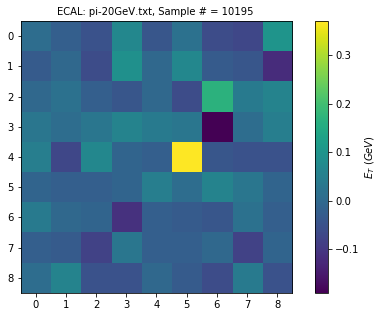

In [14]:
plt.figure(figsize=(8,5))
plt.imshow(np.array(img9x9[key][smp_num]).reshape((9,9)))
cbar = plt.colorbar()
cbar.set_label(r'$E_T\ (GeV)$')
plt.title('ECAL: {}, Sample # = {} '.format(key,smp_num),
         fontsize=10)
plt.xticks(np.arange(0,9,1))
plt.show()

Visualizing the $9\times9$ average signal response from the randomly selected energy:

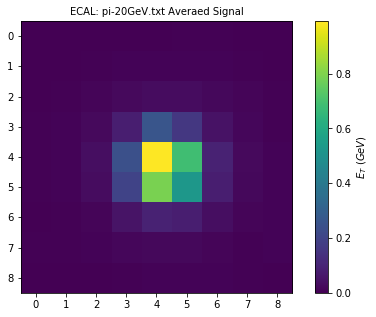

In [15]:
plt.figure(figsize=(8,5))
plt.imshow(np.mean(img9x9[key],axis=0).reshape((9,9)))
cbar = plt.colorbar()
cbar.set_label(r'$E_{T}\ (GeV)$')
plt.title('ECAL: {} Averaed Signal'.format(key),
         fontsize=10)
plt.xticks(np.arange(0,9,1))
plt.show()

## 2.  Upsampling HCal Data
Convert the $3\times4$ HCal image to an $9\times9$ image so that the training input can be representative of the physical situation where the surface areas are the same.

### Define the function for conversion
The pixel values are scaled such that the total beam energy of the original $3\times4$ image is preserved.  

In [16]:
def convert34to99(org):
    new = np.zeros(81) # place holder for new image
    count = 0
    for i in range(0,3): # Runs through all 3 rows of the 3x4 image
        for j in range(0,3): # Scales 3x4 row to 3 of the 9x9 rows
            index_new = np.int(count)
            index_old = np.int(4*i)
            new[index_new] = org[index_old] / 6.0
            new[index_new + 1] = org[index_old] / 6.0
            new[index_new + 2] = org[index_old + 1] / 9.0
            new[index_new + 3] = org[index_old + 1] / 9.0
            new[index_new + 4] = org[index_old + 1] / 9.0
            new[index_new + 5] = org[index_old + 2] / 9.0
            new[index_new + 6] = org[index_old + 2] / 9.0
            new[index_new + 7] = org[index_old + 2] / 9.0
            new[index_new + 8] = org[index_old + 3] / 3.0
            count += 9
    return new

### Process the images

In [17]:
img3x4_scaled = {} # declare the scaled image 

start_time = time.time()
for dset in img3x4:
    print("Scaling 3x4 to 9x9 images for {}".format(dset))
    image_buffer = []
    for i in img3x4[dset]:
        image_buffer.append(convert34to99(i))
    img3x4_scaled[dset] = image_buffer
elapsed_time = time.time() - start_time
print("Elapsed time: {} seconds".format(elapsed_time))

Scaling 3x4 to 9x9 images for pi-20GeV.txt
Scaling 3x4 to 9x9 images for pi-30GeV.txt
Scaling 3x4 to 9x9 images for pi-4GeV.txt
Scaling 3x4 to 9x9 images for pi-100GeV.txt
Scaling 3x4 to 9x9 images for pi-200GeV.txt
Scaling 3x4 to 9x9 images for pi-300GeV.txt
Scaling 3x4 to 9x9 images for pi-3GeV.txt
Scaling 3x4 to 9x9 images for pi-5GeV.txt
Scaling 3x4 to 9x9 images for pi-6GeV.txt
Scaling 3x4 to 9x9 images for pi-150GeV.txt
Scaling 3x4 to 9x9 images for pi-2GeV.txt
Scaling 3x4 to 9x9 images for pi-50GeV.txt
Scaling 3x4 to 9x9 images for pi-8GeV.txt
Scaling 3x4 to 9x9 images for pi-9GeV.txt
Elapsed time: 7.30385899544 seconds


### Visualize the scaled HCal image:

In [18]:
# Choosing the sample for the 3x4 data
key_num_2 = np.random.randint(0,np.size(files34.keys())-1)

# key_num_2 = # can fix the data file viewed
key_2 = list(files34.keys())[key_num_2]
smp_num_2 = np.random.randint(0,np.shape(img3x4_scaled[key_2])[0]-1)
# smp_num_2 = # can fix the sample number viewed

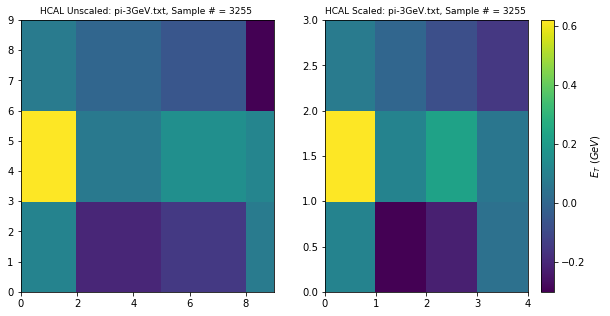

In [19]:
fig2, (ax21, ax22) = plt.subplots(ncols=2,figsize=(10,5))
# Plotting unscaled and the two scaled images
val21 = (np.array(img3x4_scaled[key_2][smp_num_2]).reshape((9,9))) 
val22 = (np.array(img3x4[key_2][smp_num_2]).reshape((3,4)))
# Color mapping the data
im21 = ax21.pcolormesh(val21)
im22 = ax22.pcolormesh(val22)
# Single color map scale since the same sample 
cbar = fig2.colorbar(im22)
cbar.set_label(r'$E_T\ (GeV)$')
ax21.set_title('HCAL Unscaled: {}, Sample # = {} '.format(key_2,smp_num_2),
         fontsize=9)
ax22.set_title('HCAL Scaled: {}, Sample # = {} '.format(key_2,smp_num_2),
         fontsize=9)
plt.show()

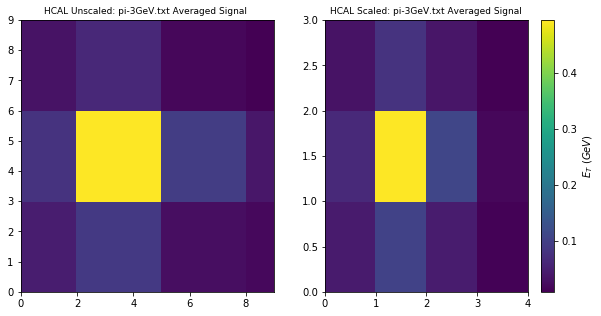

In [20]:
fig2, (ax21, ax22) = plt.subplots(ncols=2,figsize=(10,5))
# Plotting unscaled and the two scaled images
val21 = np.mean(img3x4_scaled[key_2],axis=0).reshape((9,9))
val22 = np.mean(img3x4[key_2],axis=0).reshape((3,4))
# Color mapping the data
im21 = ax21.pcolormesh(val21)
im22 = ax22.pcolormesh(val22)
# Single color map scale since the same sample 
cbar = fig2.colorbar(im22)
cbar.set_label(r'$E_T\ (GeV)$')
ax21.set_title('HCAL Unscaled: {} Averaged Signal '.format(key_2),
         fontsize=9)
ax22.set_title('HCAL Scaled: {} Averaged Signal'.format(key_2),
         fontsize=9)
plt.show()

## 3.  Appending and Partioning
Since each energy dataset does not have the same number of data points, we want to sample from each dataset the number associated with the dataset with the fewest samples.  This prevents overfitting on one particular energy type.

In [21]:
# Determine the minimal number of samples in the energy datasets
samples = [] # array to hold MIN_SAMPLES candidates
for i in img9x9:
    samples.append(np.shape(img9x9[i])[0])

In [22]:
# Initialize the editable variables
MIN_SAMPLES = min(samples)
RATIO = 0.05 # fraction of sample that will be test data
RNG_SPLIT = np.random.randint(0,100) # choose the seed for deciding how to split the training and validation data
# rng_split = 0 # set this for same split

# Declare the lists that will hold the data
x_all = [] # contains appended data for both training and testing
y = [] # contains truth values for training

### Append the $9\times9$ and $3\times4$ data together.
(Optional) Using `random` to turn on the random selection for images used from `img9x9` and `img3x4_scaled`.  An array `selection` is created with unique numbers sampled from the defined range of the minimal sample number.  The percentage of samples used from each energy dataset is output during the appending.

In [23]:
start_time = time.time()

for i in img9x9:
    num_energy = np.shape(img9x9[i])[0] # entries for a given energy
    perc_smp = np.around((float(MIN_SAMPLES) / num_energy),3)
    print('{}: {} % images used'.format(i,perc_smp*100))
    img_EB = np.array(img9x9[i])
    img_HB = np.array(img3x4_scaled[i])
    img_comb_arr = [] # buffer for img_comb
    
    selection = random.sample(range(num_energy),img_EB.shape[0])
    for j in range(img_EB.shape[0]):
        # p = j # use this pointer for static, ordered selection
        p = selection[j] # this pointer for dynamic, unordered selection
        # combining the ECal and HCal data and compiling
        img_comb_buffer = np.concatenate((img_EB[p],img_HB[p]))
        img_comb_arr.append(img_comb_buffer)
        
    img_comb = np.array(img_comb_arr) # numpy array assignment

    x_all.extend(img_comb[0:MIN_SAMPLES,:])
    
    # associate truth value array with the training and testing sets
    energy = np.int(re.findall(r'\d+',i)[0]) # extracts energy value
    y.extend(np.full(MIN_SAMPLES,energy)) # populates the truth dataset
    
elapsed_time = time.time() - start_time
print('Elapsed time: {} seconds'.format(elapsed_time))
a = np.shape(x_all)[0]
b = MIN_SAMPLES * np.size(files)
print('x_all has {} images; expected {} images.'.format(a,b))

pi-20GeV.txt: 49.4 % images used
pi-30GeV.txt: 100.0 % images used
pi-4GeV.txt: 25.2 % images used
pi-100GeV.txt: 50.7 % images used
pi-200GeV.txt: 81.8 % images used
pi-300GeV.txt: 26.2 % images used
pi-3GeV.txt: 30.6 % images used
pi-5GeV.txt: 18.4 % images used
pi-6GeV.txt: 18.5 % images used
pi-150GeV.txt: 69.1 % images used
pi-2GeV.txt: 70.9 % images used
pi-50GeV.txt: 58.5 % images used
pi-8GeV.txt: 37.7 % images used
pi-9GeV.txt: 25.6 % images used
Elapsed time: 5.253937006 seconds
x_all has 103236 images; expected 103236 images.


### Partition the data into training/validation and testing sets
Can modify the ratio of the split by editing `RATIO` and can turn on/off the random splitting.

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y,
                                test_size = RATIO,
                                random_state = RNG_SPLIT)

## 4.  Preprocessing
Set the values for the mean and rms for the entire training dataset to have $\mu=0$ and $\sigma=1$ which allows for better, more efficient, training by the network.  Thus, the CNN will produce a model that takes preprocessed beam data as its input, necessarily preprocessed using the same parameters as that of the training set.

In [25]:
scaler = StandardScaler().fit(x_train) # scales for training
x_train_pp = scaler.transform(x_train) # using this in DNN
x_test_pp = scaler.transform(x_test) # using this in DNN

# save the scaler parameters
joblib.dump(scaler, model_dir + "CNN Scaler " + tag + ".joblib")

['CNN model/2019-07-16/CNN Scaler 07-16 (21).joblib']

### Visualize the preprocessed data compared to the original data:

In [26]:
NBIN = 300 # set this, currently using a value such that 1 bin is approx 1 GeV

x_train_pp_flat = np.ndarray.flatten(x_train_pp)

# Testing inverse transform
x_train_it = scaler.inverse_transform(x_train_pp)
x_train_it_flat = np.ndarray.flatten(x_train_it)

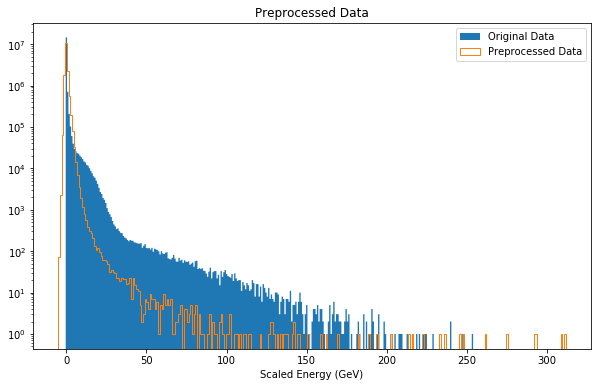

Mean of Original: 0.3662 (GeV)
Standard Deviation of Original: 2.2419 (GeV)
Mean of Preprocessed: 0.0 (GeV)
Standard Deviation of Preprocessed: 1.0 (GeV)


In [27]:
plt.close()
plt.figure(figsize = (10,6))
plt.hist(x_train_it_flat, NBIN,
        histtype = 'stepfilled',
        label = 'Original Data')
plt.hist(x_train_pp_flat, NBIN,
        histtype = 'step',
        label = 'Preprocessed Data')
plt.title('Preprocessed Data')
plt.xlabel('Scaled Energy (GeV)')
plt.yscale('log')
plt.legend(loc = 'best')
plt.show()

# Compute the statistics to confirm
mean_OG = np.around(np.average(x_train_it_flat),4)
std_OG = np.around(np.std(x_train_it_flat),4)

mean_PP = np.around(np.average(x_train_pp_flat),4)
std_PP = np.around(np.std(x_train_pp_flat),4)

print ('Mean of Original: {} (GeV)'.format(mean_OG))
print ('Standard Deviation of Original: {} (GeV)'.format(std_OG))

print ('Mean of Preprocessed: {} (GeV)'.format(mean_PP))
print ('Standard Deviation of Preprocessed: {} (GeV)'.format(std_PP))

### Recompile the $9\times9$ preprocessed images

In [28]:
x_train_im_pp = []
#x_train_im = []
for i in range(len(x_train_pp)):
    x_train_im_pp.append(x_train_pp[i].reshape((2,9,9)))
    #x_train_im.append(x_train[i].reshape((2,9,9)))

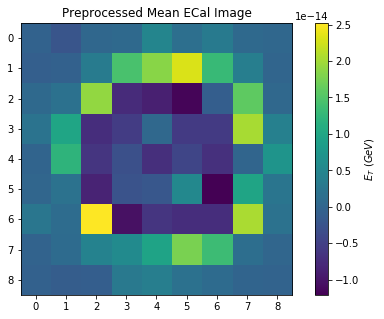

In [29]:
plt.figure(figsize=(8,5))
plt.imshow(np.mean(np.array(x_train_im_pp)[:,0,:,:], axis = 0))
cbar = plt.colorbar()
cbar.set_label(r'$E_T\ (GeV)$')
plt.xticks(np.arange(0,9,1))
plt.title('Preprocessed Mean ECal Image')
plt.show()

# 5.  Define the CNN
All the editable parameters related to the CNN construction and training are initialized below.
Non-traininable parameters that can be potentially optimized include:
> 1. Activation Function (Regression): https://keras.io/activations/ or https://keras.io/layers/advanced-activations/ (trainable activation functions)
> 2. Optimizer: https://keras.io/optimizers/ 
> 3. Patience: use at least $10$ to avoid premature early stopping

In [30]:
def customLoss(y_true, y_pred):
    def _logcosh(x):
        return x + backend.softplus(-2. * x) - backend.log(2.)
    return backend.mean(_logcosh((y_pred - y_true) / y_true), axis = -1)

In [31]:
# initialize the editable variables

# LOSS_FUNC = 'mean_squared_error' # set this
# LOSS_FUNC = 'mean_absolute_error'
LOSS_FUNC = customLoss
PATIENCE = 20 # number of epochs for worsening loss before early stopping 

# Optimization parameter space
KERNEL = [2,3]
FILTER = [15,30]
CONV = [1,2]
HIDDEN = [1,2]
NODES = [20,100]
DROPOUT = [0.4,0.6]
BATCH_SIZE = [50,100]
LRATE = [5e-5,1e-4]
NCALLS = 8
NSTARTS = 6 # number of random points sampled to begin with

INPUT_DIM = 162 # number of data points being fed into neural network
INITIALIZER = 'he_normal'
ACTIVATION = 'softplus' # alternatives to ReLU include SeLU, ELU, etc...
ACTIVATION_CNN = 'elu' # set this
OPTIMIZER = Adam(lr = LRATE[0]) # learning rate set arbitrarily for now, will be optimized
OPT_STR = 'adam' # edit this if editing OPTIMIZER
EPOCHS = 1000 # epochs used in the actual training
EPOCHS_OPT = 100 # epochs used in optimization
VSPLIT = 0.15 # ratio of x_train being used for validation

RNG_OPT = np.random.randint(0,100)
# RNG_OPT = 1 # set this for consistency

Begin by defining the early stopping parameters to avoid overfitting and saving the existing "best" model during the optimization.

In [32]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                                   patience = PATIENCE)

# saves optimal model
model_checkpoint = ModelCheckpoint(model_dir + 'CNN Model ' + tag + '.h5',
                                monitor = 'val_loss',
                                verbose = 0, 
                                save_best_only = True,
                                save_weights_only = False,
                                mode = 'auto',
                                period = 1)

## 6.  Optimize the CNN

### Define the functions for customization
Three key parts to the optimization:
> 1. Neural Network compiler method:  the general framework of the network is defined here and takes in arguments that are to be optimized
> 2. Parameter space:  should include all the hyperparameters being optimized with the min and max values of the surveyed space
> 3. Main `objective` method:  this method will be iterated during the optimization, which can include user-defined outputs

In [33]:
space = [
        Integer(KERNEL[0], KERNEL[1], name = 'kernel_size'),
        Integer(FILTER[0], FILTER[1], name = 'filter_size'),
        Integer(CONV[0], CONV[1], name  = 'convolutional_layers'),
        Integer(HIDDEN[0], HIDDEN[1], name = 'hidden_layers'),
        Integer(NODES[0], NODES[1], name = 'initial_nodes'),
        Real(DROPOUT[0], DROPOUT[1], name = 'dropout'),
        Integer(BATCH_SIZE[0], BATCH_SIZE[1], name = 'batch_size'),
        Real(LRATE[0], LRATE[1], 'log-uniform', name = 'learning_rate')
]

In [34]:
def build_custom_model(kernel = KERNEL[0], filters = FILTER[0], conv = CONV[0], 
                       hidden = HIDDEN[0], nodes = NODES[0],
                       dropout = DROPOUT[0], lrate = LRATE[0]):
    model = Sequential()
    
    model.add(Conv2D(filters, activation = ACTIVATION_CNN, kernel_size = kernel,
                    input_shape = np.shape(x_train_im_pp[0]),
                    data_format = 'channels_first',
                    kernel_initializer = INITIALIZER,
                    padding = 'same', # turns zero-padding off, to turn on use 'same'
                    strides = (1,1))) # explicitly state the kernel motion
    model.add(BatchNormalization()) # apply batch normalization before ELU but after ReLU
    
    count = 0
    for i in range(conv - 1):
        count += 1
        filter_buffer = int(round((filters / np.power(2,count))))
        if (filter_buffer < 2):
            filter_buffer == 2
        model.add(Conv2D(filter_buffer, activation = ACTIVATION_CNN, kernel_size = kernel,
                        kernel_initializer = INITIALIZER,
                        padding = 'same',
                        data_format = 'channels_first',
                        strides = (1,1))) # explicitly state the kernel motion
        model.add(BatchNormalization())
    
    model.add(Flatten()) # makes the 9x9x2 input readable into the CNN
    
    count = 0
    for i in range(hidden):
        if (i%2!=0):
            count += 1
        node_buffer = int(round((nodes / np.power(2,count))))
        if (node_buffer == 0):
            node_buffer = 2
        model.add(Dropout(dropout))
        model.add(Dense(node_buffer, activation = ACTIVATION))
    model.add(Dense(1, kernel_initializer = INITIALIZER))

    model.compile(optimizer = Adam(lr = lrate),
             loss = LOSS_FUNC,
             metrics = [LOSS_FUNC])

    return model

@use_named_args(space)
def objective(**X):
    print('New configuration: {}'.format(X))

    model = build_custom_model(
        kernel = X['kernel_size'],
        filters = X['filter_size'],
        conv = X['convolutional_layers'],
        hidden = X['hidden_layers'],
        nodes = X['initial_nodes'],
        dropout = X['dropout'],
        lrate = X['learning_rate']
    )
    model.summary()
    history = model.fit(np.array(x_train_im_pp), np.array(y_train),
                    epochs = EPOCHS_OPT,
                    batch_size = X['batch_size'],
                    shuffle = True,
                    verbose = 1,
                    callbacks = [early_stopping, model_checkpoint],
                    validation_split = VSPLIT)
    BEST_LOSS = min(history.history['val_loss']) # want to minimize this    
    LOSS_WEIGHT = history.history['val_loss'].index(BEST_LOSS) + 1
    WEIGHT_LOSS = np.around((BEST_LOSS / LOSS_WEIGHT), 6)
    
    del model
    backend.clear_session()
    backend.reset_uids()
    
    print('Best weighted validation loss: {}'.format(WEIGHT_LOSS))
    print('\n')
    return WEIGHT_LOSS

## Optimize with Scikit-Optimize
`gp_minimize` is Scikit's Gaussian process/prior optimizer which reads in:
> 1. __Objective__: the method being iterated through containing model creation and training
> 2. __Dimensions__: the parameter space array
> 3. __n_calls__: the number of iterations for optimization (default requires at least $10$ calls
> 4. __Acquisition function__: function to minimize over Gaussian prior (default is a probabilitic decision between lower confidence bound, negative expected improvement, or negative probability of improvement)

After defining the three key parts for the optimization, each is fed into one of the optimization functions: https://scikit-optimize.github.io/optimizer/index.html and produces an object `res` which contains the optimization information, described later.  The output form the minimizer whilst running shows the model being tested and its associated hyperparameters and the resulting losses for training and validation sets.  The epochs used during optimization are reduced compared to the subsequent training on the optimized model to save time.

It then returns an object `res` that contains:
> 1. `res.x`: location of minimum in parameter space
> 2. `res.fun`: minimum loss function
> 3. `res.x_iters`: list of surveyed parameter space per iteration
> 4. `res.func_vals`: array of loss function at each iteration

In [35]:
backend.clear_session() # this clears the cache for the model layers
start_time = time.time()
res_gp = gp_minimize(func = objective,
                     dimensions = space,
                     n_calls = NCALLS,
                     n_random_starts = NSTARTS,
                     verbose = True)
print('Finished optimization in: {} s'.format(time.time()-start_time))

W0716 21:09:42.598764 140633284712256 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0716 21:09:42.600333 140633284712256 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0716 21:09:42.604221 140633284712256 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 21:09:42.620990 140633284712256 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg

Iteration No: 1 started. Evaluating function at random point.
New configuration: {'hidden_layers': 2, 'initial_nodes': 22, 'convolutional_layers': 2, 'batch_size': 93, 'filter_size': 22, 'dropout': 0.5603679539338672, 'learning_rate': 5.24435036345788e-05, 'kernel_size': 3}


W0716 21:09:42.933289 140633284712256 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0716 21:09:42.934773 140633284712256 nn_ops.py:4224] Large dropout rate: 0.560368 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0716 21:09:42.974813 140633284712256 nn_ops.py:4224] Large dropout rate: 0.560368 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0716 21:09:43.782879 140633284712256 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/optimizers.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 9, 9)          418       
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 9, 9)          36        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 9, 9)          2189      
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 9, 9)          36        
_________________________________________________________________
flatten_1 (Flatten)          (None, 891)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 891)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                19624     
__________

W0716 22:11:56.356005 140633284712256 nn_ops.py:4224] Large dropout rate: 0.542893 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0716 22:11:56.407396 140633284712256 nn_ops.py:4224] Large dropout rate: 0.542893 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 9, 9)          570       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 9, 9)          36        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 9, 9)          4065      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 9, 9)          36        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1215)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1215)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 49)                59584     
__________

W0716 22:39:41.647561 140633284712256 nn_ops.py:4224] Large dropout rate: 0.591162 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 9, 9)          270       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 9, 9)          36        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2430)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2430)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               243100    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 243,507
Trainable params: 243,489
Non-trainable params: 18
_________________________________________________________________
Tra

### Visualize the improvement
Plotting: 
> 1. __Convergence Plot__: shows the global minimal loss per optimization iteration. 
> 2. __Evaluation Plot__: shows the sampling frequency in each parameter space.
> 3. __Objective Plot__: shows the partial dependence (i.e. influence) of each parameter being surveyed.  The partial dependence is essentially computed by averaging out the effect of all other hyperparameters for that given hyperparameter choice, hence the more calls, the more illustrative the objective plot.

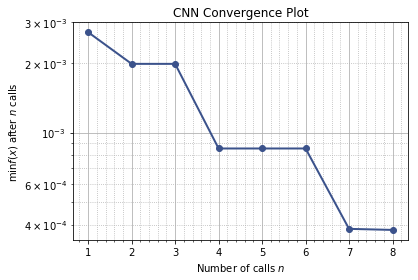

Best parameters for the CNN:     
  Kernel Size = 2     
  Filter Size = 30     
  Convolutional Layers = 1     
  Hidden Layers = 1     
  Initial Nodes = 100     
  Dropout = 0.591162004924     
  Batch Size = 62     
  Learning Rate = 9.32426545456e-05


In [36]:
plt.close()
plot_convergence(res_gp, size = 10)
plt.yscale('log')
plt.title('CNN Convergence Plot')
plt.minorticks_on()
plt.grid(b = 'True', which = 'minor', linestyle = ':')
plt.savefig(model_dir + 'CNN Convergence ' + tag + '.png')
plt.show()

x_list = ['Kernel Size','Filter Size','Convolutional Layers',
          'Hidden Layers','Initial Nodes','Dropout',
         'Batch Size','Learning Rate']

print('Best parameters for the CNN: \
    \n  Kernel Size = {} \
    \n  Filter Size = {} \
    \n  Convolutional Layers = {} \
    \n  Hidden Layers = {} \
    \n  Initial Nodes = {} \
    \n  Dropout = {} \
    \n  Batch Size = {} \
    \n  Learning Rate = {}'.format(res_gp.x[0],res_gp.x[1],res_gp.x[2],
                                 res_gp.x[3],res_gp.x[4],res_gp.x[5],
                                  res_gp.x[6],res_gp.x[7]))

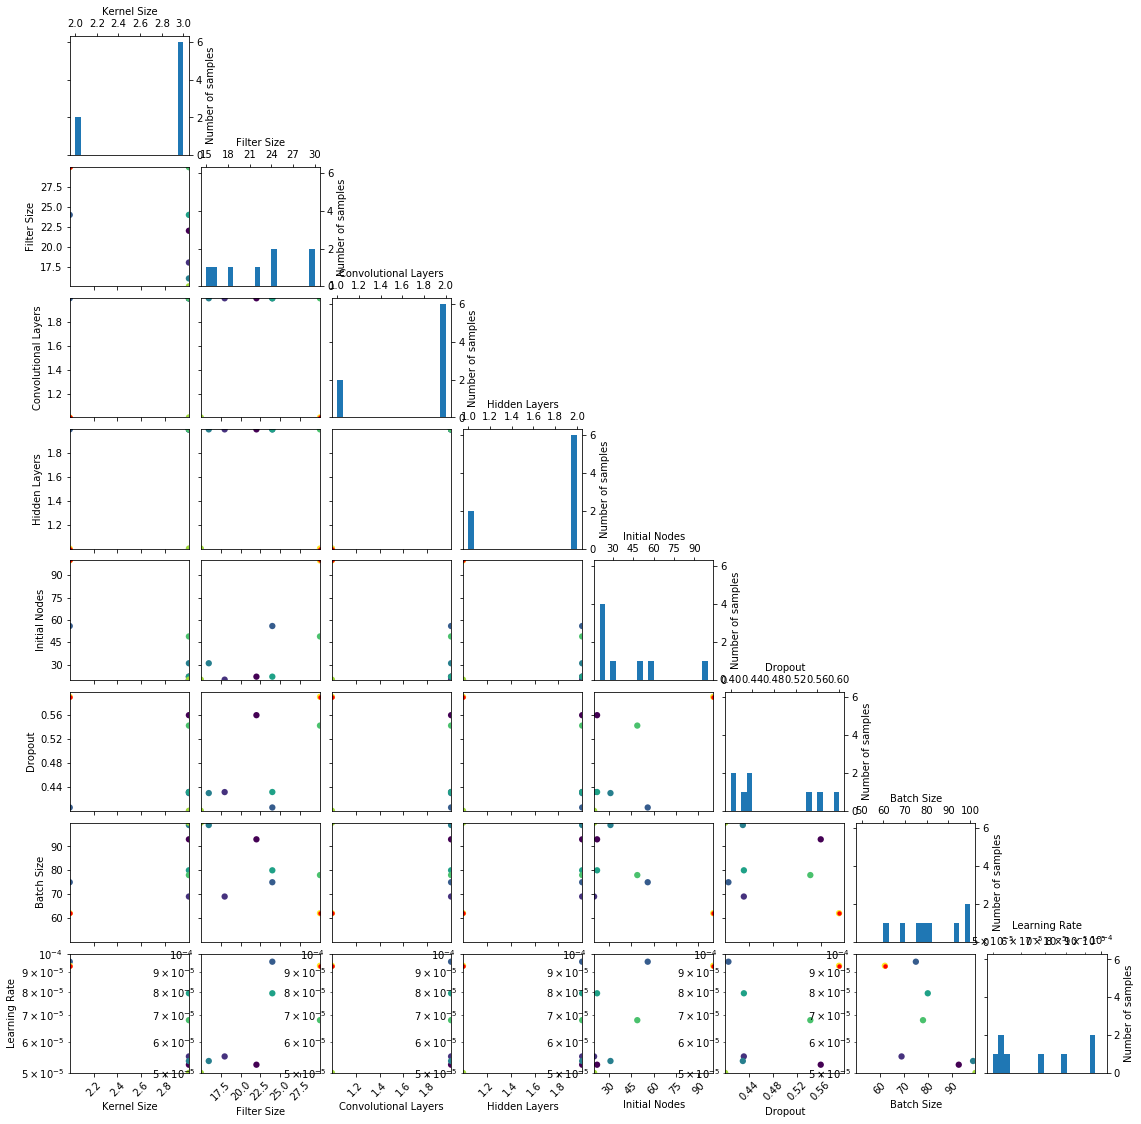

In [37]:
plt.close()
plot_evaluations(res_gp, bins = 20, dimensions = x_list)
plt.savefig(model_dir + 'CNN Sample Frequency ' + tag + '.png')
plt.show()

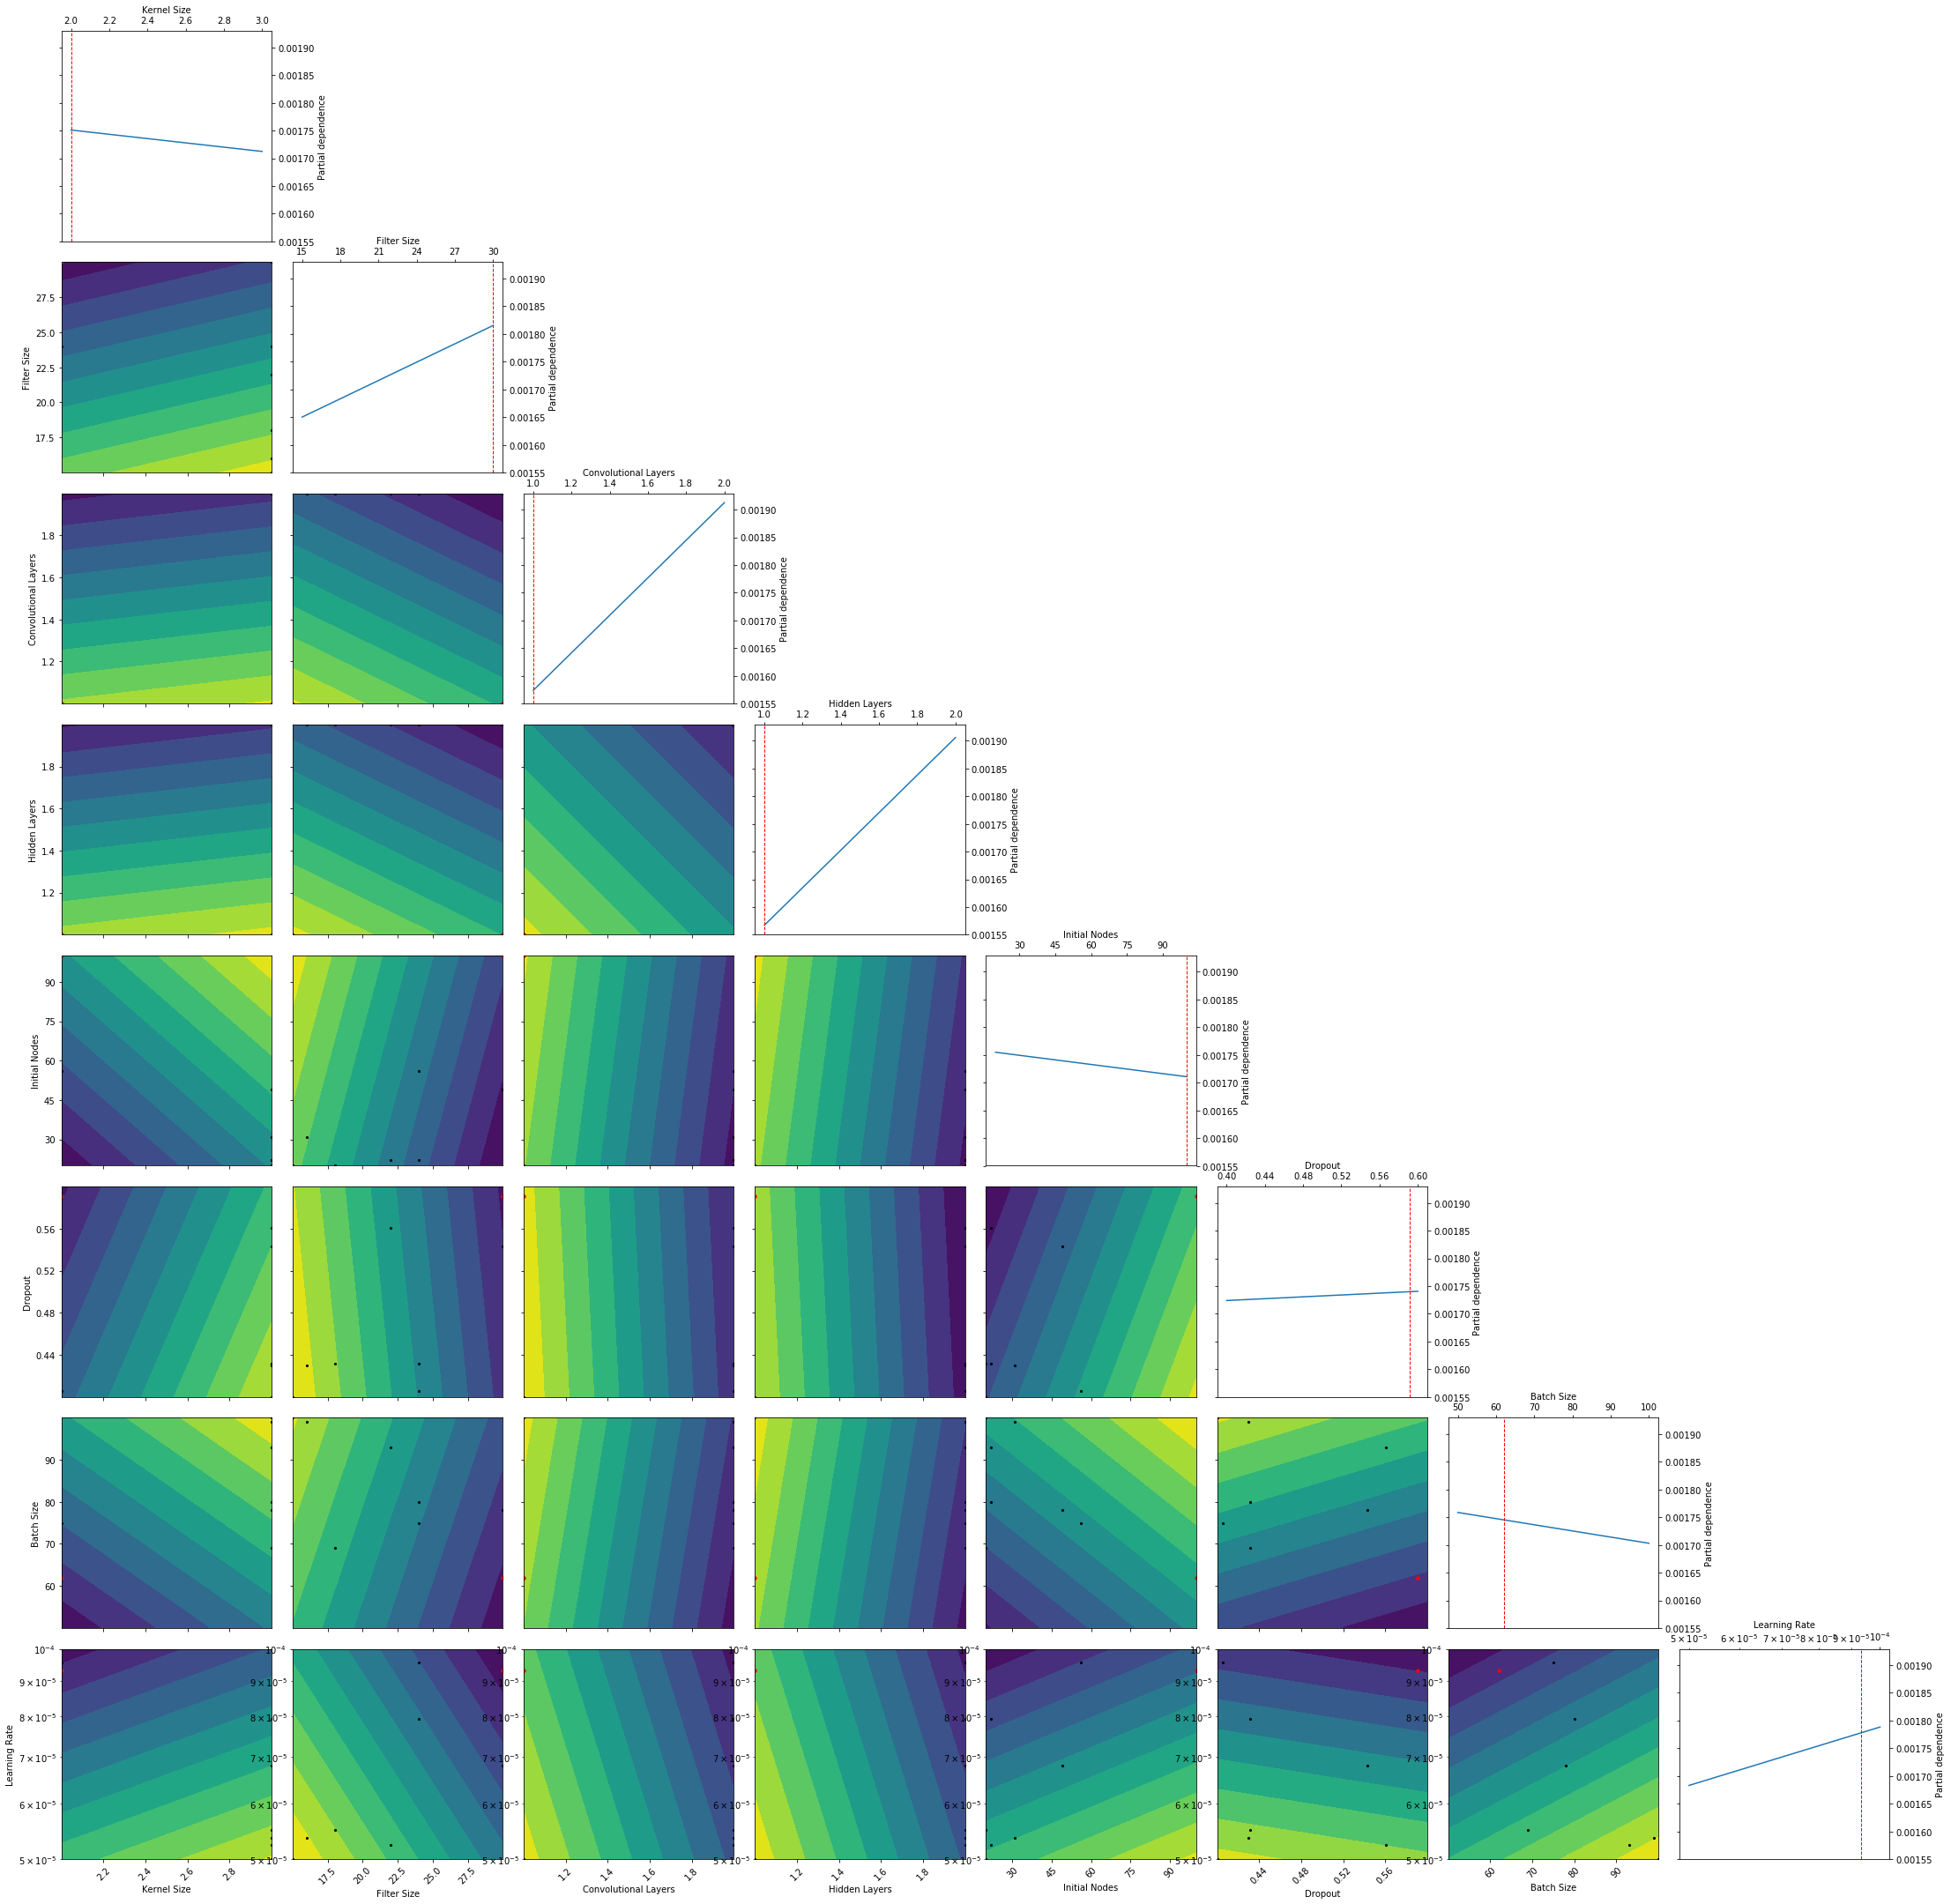

In [38]:
plt.close()
plot_objective(res_gp, size = 4, dimensions = x_list)
plt.savefig(model_dir + 'CNN Objective' + tag + '.png')
plt.show()

# 7.  CNN Training and Prediction
`res_gp` contains the optimized model which will be used to implement a full training on the same training, validation and testing split.  The model is constructed as before.

In [39]:
# Initialize the editable variables
linfit_range = np.linspace(0,0.8,100) # x-axis range for linear fit

# Declare some dict containers to contain fit parameters by energy label
pred_mu_test = {} 
pred_sigma_test = {}
pred_res_test = {}
pred_det_test = {}

raw_det_test = {}
raw_res_test = {}
raw_mu_test = {}
raw_sigma_test = {}

raw_res_list_test = [] # list containing raw resolution values
pred_res_list_test = [] # list containing predicted resolution values

raw_eng_list_test = [] # list containing raw energy values
pred_eng_list_test = [] # list containing predicted energy values

raw_sigma_list_test = [] 
pred_sigma_list_test = []

nom_eng_list_test = []

x_test_e = {} # holds the preprocessed data with energy labels
x_test_o = {} # holds the original data with energy labels

In [40]:
# Populate some arrays
for energy in set(y_test):
    x_test_e[energy] = [] # initialize the dict categories with energy labels
    x_test_o[energy] = []
for i in range(len(y_test)):
    x_test_e[y_test[i]].append(x_test_pp[i]) # orders the data points by energy
    x_test_o[y_test[i]].append(x_test[i])

### Build the CNN using the optimized parameters

In [41]:
backend.clear_session()
MODEL_OPT = Sequential()
MODEL_OPT.add(Conv2D(res_gp.x[1], activation = ACTIVATION_CNN,
        kernel_size = res_gp.x[0],
        input_shape = np.shape(x_train_im_pp[0]),
        data_format = 'channels_first',
        kernel_initializer = INITIALIZER,
        padding = 'same'))
                  
MODEL_OPT.add(BatchNormalization())
                  
count = 0
for i in range(res_gp.x[2] - 1):
    count += 1
    filter_buffer = int(round((res_gp.x[1] / np.power(2,count))))
    if (filter_buffer == 0):
        filter_buffer == 2
    MODEL_OPT.add(Conv2D(filter_buffer, activation = ACTIVATION_CNN,
                kernel_size = res_gp.x[0], kernel_initializer = INITIALIZER,
                padding = 'same',
                data_format = 'channels_first'))
    MODEL_OPT.add(BatchNormalization())

MODEL_OPT.add(Flatten())
                  
count = 0
for i in range(res_gp.x[3]):
    node_buffer = int(round((res_gp.x[4] / np.power(2,count))))
    if (node_buffer == 0):
        node_buffer = 2
    MODEL_OPT.add(Dropout(res_gp.x[5]))
    MODEL_OPT.add(Dense(node_buffer, activation = ACTIVATION))
MODEL_OPT.add(Dense(1, kernel_initializer = INITIALIZER))

MODEL_OPT.compile(optimizer = Adam(lr = res_gp.x[7]),
        loss = LOSS_FUNC,
        metrics = [LOSS_FUNC])

MODEL_OPT.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 9, 9)          270       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 9, 9)          36        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2430)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2430)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               243100    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 243,507
Trainable params: 243,489
Non-trainable params: 18
_________________________________________________________________


### Train the optimized model

In [42]:
HISTORY_OPT = MODEL_OPT.fit(np.array(x_train_im_pp),np.array(y_train),
                       batch_size = res_gp.x[6],
                       epochs = EPOCHS,
                       verbose = 1,
                       shuffle = True,
                       callbacks = [early_stopping, model_checkpoint],
                       validation_split = VSPLIT)

Train on 83362 samples, validate on 14712 samples
Epoch 1/1000
83362/83362 [==============================] - 24s 282us/step - loss: 0.1599 - customLoss: 0.1599 - val_loss: 0.0835 - val_customLoss: 0.0835
Epoch 2/1000
83362/83362 [==============================] - 23s 278us/step - loss: 0.0694 - customLoss: 0.0694 - val_loss: 0.0563 - val_customLoss: 0.0563
Epoch 3/1000
83362/83362 [==============================] - 23s 271us/step - loss: 0.0598 - customLoss: 0.0598 - val_loss: 0.0558 - val_customLoss: 0.0558
Epoch 4/1000
83362/83362 [==============================] - 19s 232us/step - loss: 0.0560 - customLoss: 0.0560 - val_loss: 0.0557 - val_customLoss: 0.0557
Epoch 5/1000
83362/83362 [==============================] - 23s 278us/step - loss: 0.0535 - customLoss: 0.0535 - val_loss: 0.0525 - val_customLoss: 0.0525
Epoch 6/1000
83362/83362 [==============================] - 22s 261us/step - loss: 0.0522 - customLoss: 0.0522 - val_loss: 0.0529 - val_customLoss: 0.0529
Epoch 7/1000
83362/8

### (Optional) Load in Optimized Model

In [43]:
MODEL_OPT.save(model_dir + 'CNN Model Trained ' + tag + '.h5')

### Apply predictions to the test set

In [44]:
x_test_im_pp = []
x_test_im = []
for i in range(len(x_test_pp)):
    x_test_im_pp.append(x_test_pp[i].reshape((2,9,9)))
    #x_test_im.append(x_test[i].reshape((2,9,9)))

In [45]:
# Applying combined trained network on test dataset
predictions = MODEL_OPT.predict(np.array(x_test_im_pp))
predictions = list(predictions.reshape(len(x_test_im_pp)))
raw = [x.sum() for x in np.array(x_test)]

# 8.  Visualization

### Visualize the training improvement.
Define a metrics function that shows the loss per epoch

In [46]:
def show_metrics(history,vsplit,res):
    dec = 3 # number of decimals to round the metrics to
    mse_max = max(history.history['val_loss'])
    mse_max_n = history.history['val_loss'].index(mse_max)
    mse_min = min(history.history['val_loss'])
    mse_min_n = history.history['val_loss'].index(mse_min)
    print('MSE (Validation) Range: [{},{}]'.format(np.around(mse_min,dec),
                                        np.around(mse_max,dec)))
    
    plt.close()
    plt.figure(figsize = (10,6))
    
    plt.plot(history.epoch, history.history['loss'], 
            label = 'Test Samples')
    
    plt.plot(history.epoch, history.history['val_loss'],
            label = 'Validation Samples')
    
    T = 1 - vsplit
    V = vsplit
    plt.title('MSE for Data Training:Validation = {}:{}'.format(T,V))
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.grid(b = True, which = 'both')
    plt.legend(loc = 'best')
    plt.show()
    
    print('Parameters for the CNN: \
    \n  Kernel Size = {} \
    \n  Filter Size = {} \
    \n  Convolutional Layers = {} \
    \n  Hidden Layers = {} \
    \n  Initial Nodes = {} \
    \n  Dropout = {} \
    \n  Batch Size = {} \
    \n  Learning Rate = {}'.format(res.x[0], res.x[1],
                                res.x[2], res.x[3], res.x[4],
                                res.x[5], res.x[6], res.x[7]))

MSE (Validation) Range: [0.032,0.084]


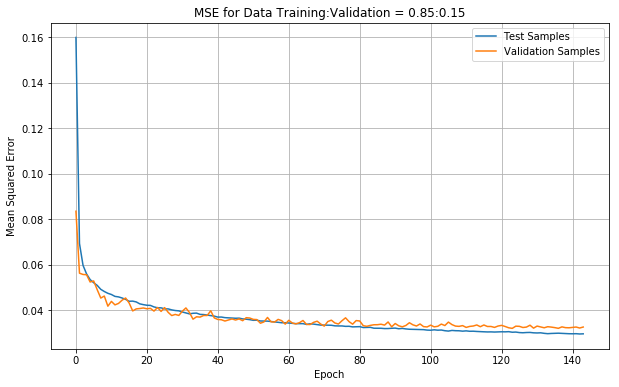

Parameters for the CNN:     
  Kernel Size = 2     
  Filter Size = 30     
  Convolutional Layers = 1     
  Hidden Layers = 1     
  Initial Nodes = 100     
  Dropout = 0.591162004924     
  Batch Size = 62     
  Learning Rate = 9.32426545456e-05


In [47]:
show_metrics(HISTORY_OPT,VSPLIT,res_gp)

The raw energy being plotted is the sum of the $162$ pixels for a single beam passing through the calorimeters.  The raw energy being displayed is not representative of the values being used in the training, since the $162$-pixel input was reduced down to a single one, which was assumedly the true beam energy. Hence, some of the values shown that reach $>400\ GeV$ are the sum of the pixel values.

# 10 Full Dataset Analysis
First, append the $9\times9$ and $3\times4$ datasets together without sampling the minimum amount.  Use a similar process as in Step 3.

### Fit the energy resolutions for the uneven test + train data split by expected energy
The preprocessed training + testing data will be predicted individually for curve fitting.

In [48]:
linfit_range = np.linspace(0,0.8,100) # x-axis range for linear fit

# Declare some dict containers to contain fit parameters by energy label
pred_mu = {} 
pred_sigma = {}
pred_res = {}
pred_det = {}

raw_det = {}
raw_res = {}
raw_mu = {}
raw_sigma = {}

raw_res_list = [] # list containing raw resolution values
pred_res_list = [] # list containing predicted resolution values

raw_eng_list = [] # list containing raw energy values
pred_eng_list = [] # list containing predicted energy values

raw_sigma_list = [] 
pred_sigma_list = []

nom_eng_list = []

In [49]:
# declare some lists
x_full = []
y_full = []

smp_tot = 0 # buffer for total number of images in dataset

# compute total dataset size
for i in img9x9:
    smp_tot += np.shape(img9x9[i])[0]

In [50]:
start_time = time.time()

for i in img9x9:
    img_EB = np.array(img9x9[i])
    img_HB = np.array(img3x4_scaled[i])
    img_comb_arr = [] # buffer for img_comb
    
    for j in range(img_EB.shape[0]):
        # combining the ECal and HCal data and compiling
        img_comb_buffer = np.concatenate((img_EB[j],img_HB[j]))
        img_comb_arr.append(img_comb_buffer)
        
    img_comb = np.array(img_comb_arr) # numpy array assignment

    x_full.extend(img_comb)
    
    # associate truth value array with the training and testing sets
    energy = np.int(re.findall(r'\d+',i)[0]) # extracts energy value
    y_full.extend(np.full(len(img9x9[i]),energy)) # populates the truth dataset
    
elapsed_time = time.time() - start_time
print('Elapsed time: {} seconds'.format(elapsed_time))

Elapsed time: 2.72058415413 seconds


Fitting for the trained data first:

In [51]:
for energy in sorted(set(y_full)): # iterates through each of the beam energies
    mask = np.argwhere(np.asarray(y_full) == energy).ravel()
    
    prediction = None

    if PREPROCESS_SCALING == True:
        x_full_pp = scaler.transform(np.asarray(x_full)[mask])
        x_full_im_pp = []
        for j in range(len(x_full_pp)):
            x_full_im_pp.append(x_full_pp[j].reshape((2,9,9)))
        prediction = MODEL_OPT.predict(np.array(x_full_im_pp))
    else:
        prediction = MODEL_OPT.predict(np.asarray(x_full)[mask].reshape((2,9,9)))

    x_full_energy = [image.sum() for image in np.asarray(x_full)[mask]]
        
    pred_mu[energy] = np.mean(prediction)
    raw_mu[energy] = np.mean(x_full_energy)
    pred_sigma[energy] = np.std(prediction)
    raw_sigma[energy] = np.std(x_full_energy)
    pred_res[energy] = np.std(prediction) / np.mean(prediction)
    raw_res[energy] = np.std(x_full_energy) / np.mean(x_full_energy)
    pred_det[energy] = prediction
    raw_det[energy] = x_full_energy
    
    pred_res_list.append( np.std(prediction) / np.mean(prediction) )
    raw_res_list.append( np.std(x_full_energy) / np.mean(x_full_energy) )
    pred_eng_list.append( np.mean(prediction) )
    raw_eng_list.append( np.mean(x_full_energy) )
    pred_sigma_list.append( np.std(prediction) )
    raw_sigma_list.append( np.mean(x_full_energy) )
    
    nom_eng_list.append( energy )

### Plotting the unevenly sampled test + train fits

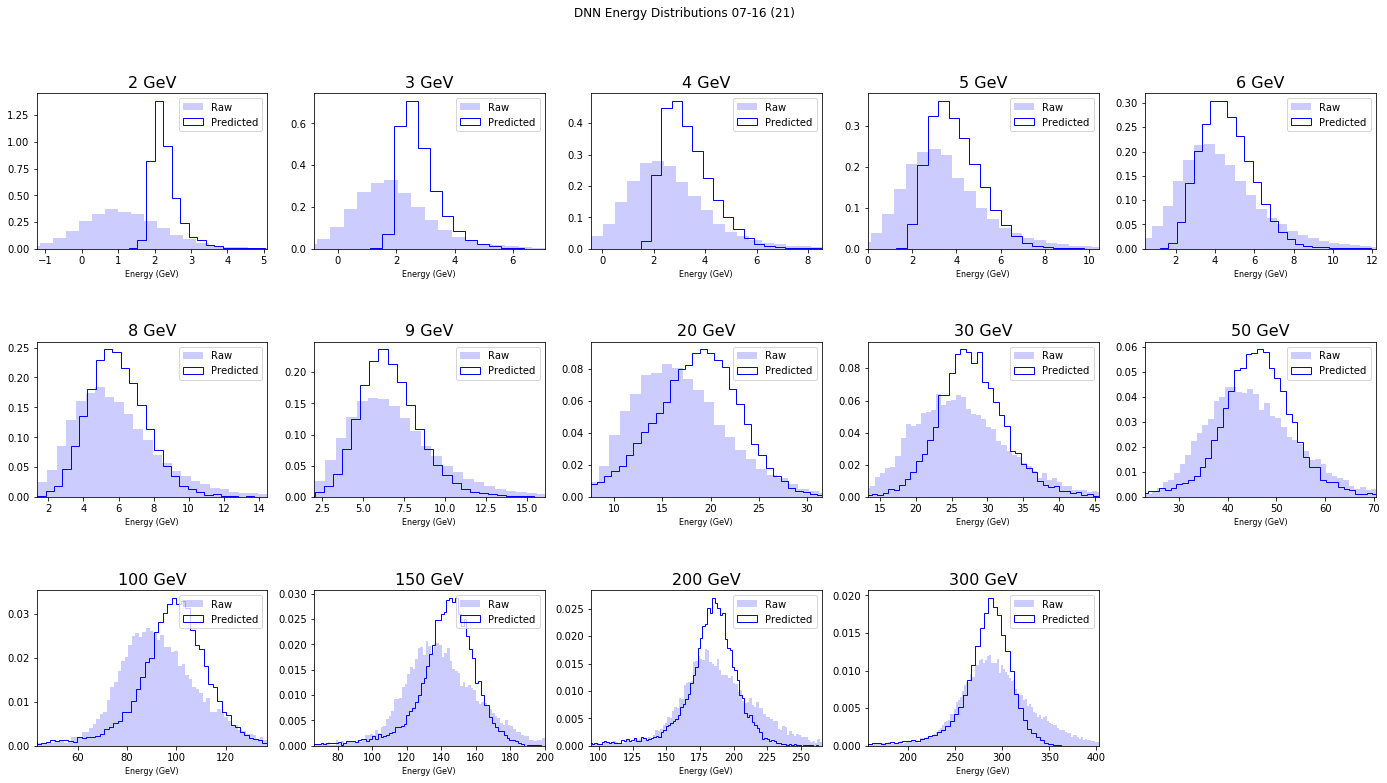

In [52]:
def rangeOf(arr):
    return max(arr) - min(arr)

plt.close()
plt.figure(figsize=(24,12))

plt.suptitle('DNN Energy Distributions ' + tag) 

fig_num = 1 # this will iterate up to populate the subplots

for energy in sorted(set(y_full)):
    plt.subplot(3, 5, fig_num)
    fig_num += 1
    
    RAW_BINS = int(np.ceil(np.sqrt(rangeOf(raw_det[energy])) * 10))
    
    plt.hist(raw_det[energy], RAW_BINS,
            histtype = 'stepfilled', density = 'True',
            alpha = 0.2,
            color = 'b',
            label = 'Raw')
    
    PRED_BINS = int(np.ceil(np.sqrt(rangeOf(pred_det[energy])) * 10))

    plt.hist(pred_det[energy], PRED_BINS,
            histtype = 'step', density = 'True',
            color = 'b',
            label = 'Predicted')
    
    plt.title('{} GeV'.format(energy), fontsize = 16)
    plt.xlabel('Energy (GeV)', fontsize = 8)
    
    
    xLOWER = min(np.percentile(raw_det[energy],1), np.percentile(pred_det[energy],1))
    xUPPER = max(np.percentile(raw_det[energy],99), np.percentile(pred_det[energy],99))
    plt.xlim(xLOWER, xUPPER)
    
    plt.subplots_adjust(hspace = 0.6)

    plt.legend(loc = 'best')

plt.savefig(model_dir + 'CNN Energy Distributions ' + tag + '.png')

plt.show()

### Uneven data Gaussian fit parameters

In [53]:
print('CNN Uneven Data Fit Parameters')

df = pd.DataFrame({'Pred Mean' : [pred_mu[i] for i in pred_mu],
            'Pred Sigma' : [pred_sigma[i] for i in pred_sigma],
            'Pred Resolution' : [pred_res[i] for i in pred_res],
            'Raw Mean' : [raw_mu[i] for i in raw_mu],
            'Raw Sigma' : [raw_sigma[i] for i in raw_sigma],
            'Raw Resolution' : [raw_res[i] for i in raw_res]},
                         pred_mu).sort_values(by = ['Pred Mean'])

df.to_csv(model_dir + 'CNN Mean and RMS ' + tag + '.txt',
                    sep = ' ', float_format = '%.5f', index = True, header = True)

print('Saving file to directory: ' + model_dir)

df

CNN Uneven Data Fit Parameters
Saving file to directory: CNN model/2019-07-16/


,Pred Mean,Pred Resolution,Pred Sigma,Raw Mean,Raw Resolution,Raw Sigma
2,2.297556,0.188933,0.434084,1.191895,1.039874,1.239421
3,2.820594,0.265605,0.749163,1.945822,0.800556,1.557740
4,3.356193,0.293970,0.986620,2.627077,0.668373,1.755867
5,3.973625,0.305953,1.215742,3.521364,0.584547,2.058404
6,4.621654,0.300878,1.390554,4.436714,0.527527,2.340488
8,5.986012,0.293190,1.755038,5.919962,0.452632,2.679564
9,6.696903,0.299687,2.006975,6.915101,0.424233,2.933616
20,18.572649,0.248132,4.608463,17.005741,0.304703,5.181700
30,27.773718,0.185660,5.156456,26.498162,0.259172,6.867592
50,45.958492,0.179426,8.246141,44.970743,0.219269,9.860697


### Plot the values for the resolutions vs the energy

In [54]:
pt_mod = 1 / np.sqrt(nom_eng_list)
# linear fit for trained data
pred_slope, pred_int, _, _, _ = stats.linregress(pt_mod,
                                        pred_res_list)

# linear fit for raw data
raw_slope, raw_int, _, _, _ = stats.linregress(pt_mod,
                                        raw_res_list)

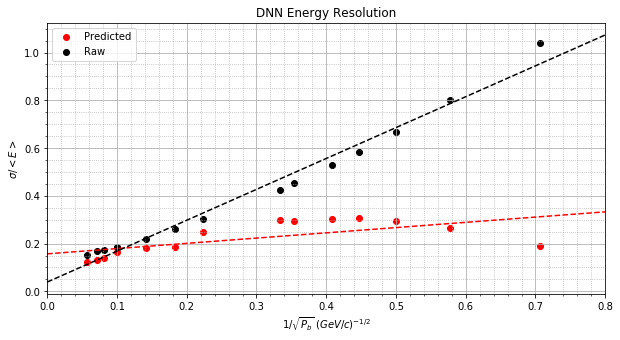

Raw Dataset Linear Regression:(a,b) = (0.219839646793,0.157042304517)
Trained Dataset Linear Regression:(a,b) = (1.29327650745,0.0389527876751)


In [55]:
def linfit(m,b,x):
    return m*x + b

plt.close()
plt.figure(figsize=(10,5))

plt.scatter(pt_mod, pred_res_list,
            marker = 'o', color = 'red',
            label = 'Predicted')
plt.plot(linfit_range, linfit(pred_slope, pred_int, linfit_range),
        linestyle = '--', color = 'red')

plt.scatter(pt_mod, raw_res_list,
            marker = 'o', color = 'black',
            label = 'Raw')
plt.plot(linfit_range, linfit(raw_slope, raw_int, linfit_range),
        linestyle = '--', color = 'black')

plt.xlabel(r'$1/\sqrt{P_{b}}\ (GeV/c)^{-1/2}$')
plt.ylabel(r'$\sigma/<E>$')
plt.xlim(0,0.8)
plt.title('DNN Energy Resolution')
plt.grid(b = True, which = 'major')
plt.grid(b = True, which = 'minor', linestyle = ':')
plt.minorticks_on()
plt.legend(loc = 'best')

plt.savefig(model_dir + 'CNN Resolution Plot ' + tag + '.png')

plt.show()

print('Raw Dataset Linear Regression:' +
    '(a,b) = ({},{})'.format(pred_slope, pred_int))
print('Trained Dataset Linear Regression:' + 
    '(a,b) = ({},{})'.format(raw_slope, raw_int))

(0.8953141690814306, 0.1049641975519831)


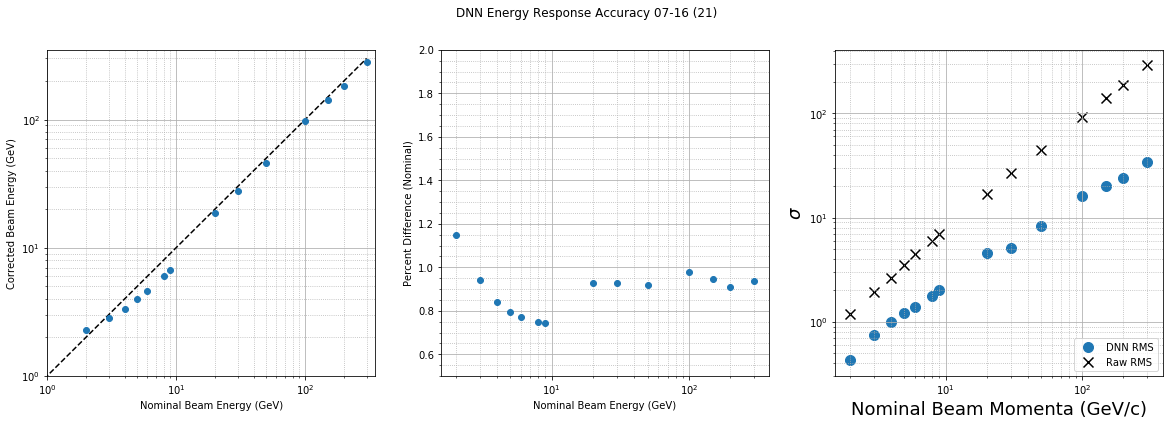

In [56]:
plt.figure(figsize=(20,6))
plt.suptitle('DNN Energy Response Accuracy ' + tag)

# left subplot
plt.subplot(131)
plt.plot(np.linspace(0,300,10),np.linspace(0,300,10),
         linestyle = '--',
         color = 'k')
plt.plot(nom_eng_list, pred_eng_list,
        marker = 'o',
        linestyle = 'none')
plt.ylabel('Corrected Beam Energy (GeV)')
plt.yscale('log')
plt.ylim(1,350)
plt.xlabel('Nominal Beam Energy (GeV)')
plt.xscale('log')
plt.xlim(1,350)
plt.grid(b = True, which = 'major')
plt.grid(b = True, which = 'minor', linestyle = ':')
plt.minorticks_on()

# compute the percent difference
nom_eng_arr = np.asarray( nom_eng_list )
pred_eng_arr = np.asarray( pred_eng_list )

ratio = pred_eng_arr / nom_eng_arr
ratio_mean = np.mean(ratio)
ratio_std = np.std(ratio)

print(ratio_mean, ratio_std)

# center subplot
plt.subplot(132)
plt.plot(nom_eng_list, ratio,
        marker = 'o',
        linestyle = 'none')
plt.ylabel('Percent Difference (Nominal)')
plt.ylim(.5,2)
plt.xlabel('Nominal Beam Energy (GeV)')
plt.xscale('log')
plt.grid(b = True, which = 'major')
plt.grid(b = True, which = 'minor', linestyle = ':')
plt.minorticks_on()

# right subplot
plt.subplot(133)
plt.scatter(nom_eng_list, pred_sigma_list,
           s = 100,
           label = 'DNN RMS')
plt.scatter(nom_eng_list, raw_sigma_list,
           marker = 'x', s = 100,
           label = 'Raw RMS',
           color = 'k')

plt.xlabel('Nominal Beam Momenta (GeV/c)',
          fontsize = 18)
plt.xscale('log')
plt.ylabel(r'$\sigma$',
          fontsize = 18)
plt.yscale('log')

plt.grid(b = True, which = 'major')
plt.grid(b = True, which = 'minor', linestyle = ':')
plt.minorticks_on()

plt.legend(loc = 4)

plt.savefig(model_dir + 'CNN Energy Response ' + tag + '.png')

plt.show()

## Save energy resolution arrays as a Numpy array file
> 1. Test Predictions
> 2. Even Test + Train Predictions
> 3. Uneven Test + Train Predictions

In [57]:
# Wrapper function for np.savetxt

def save_file(filename, x1, y1, x2, y2):
    data_arr = [x1,y1,x2,y2]

    np.save(filename, data_arr)

### Save the model parameters.  First create the text file:

In [58]:
# create the file
param_file = open(model_dir + "CNN Log File " + tag + ".txt", "w")

In [59]:
param_file.write("CNN Parameters \n")
param_file.write(datetime.datetime.today().strftime('%Y-%m-%d'))
param_file.write("\n-----------------------------------------")
param_file.write("\nOptimization Parameter Space:")
param_file.write("\n Kernel Size: [{},{}]".format(KERNEL[0],KERNEL[1]))
param_file.write("\n Filter Size: [{},{}]".format(FILTER[0],FILTER[1]))
param_file.write("\n Convolutional Layers: [{},{}]".format(CONV[0],CONV[1]))
param_file.write("\n Hidden Layers: [{},{}]".format(HIDDEN[0],HIDDEN[1]))
param_file.write("\n Initial Nodes: [{},{}]".format(NODES[0],NODES[1]))
param_file.write("\n Dropout: [{},{}]".format(DROPOUT[0],DROPOUT[1]))
param_file.write("\n Batch Size: [{},{}]".format(BATCH_SIZE[0],BATCH_SIZE[1]))
param_file.write("\n Learning Rate: [{},{}]".format(LRATE[0],LRATE[1]))
param_file.write("\n Optimization Calls: {}".format(NCALLS))
param_file.write("\n Random Calls: {}".format(NSTARTS))
param_file.write("\n Optimize / Train Epochs: {} / {}".format(EPOCHS_OPT,
                                                          EPOCHS))
param_file.write("\n Activation Functions (Conv,Dense): {},{}".format(ACTIVATION, ACTIVATION_CNN))
param_file.write("\n Optimizer: {}".format(OPT_STR))
param_file.write("\n Validation:Training Split: {}".format(VSPLIT))
param_file.write("\n-----------------------------------------")
param_file.write("\nOptimized Combined CNN Model:")
param_file.write("\n  > Kernel Size: {}".format(res_gp.x[0]))
param_file.write("\n  > Filter Size: {}".format(res_gp.x[1]))
param_file.write("\n  > Convolutional Layers: {}".format(res_gp.x[2]))
param_file.write("\n  > Hidden Layers: {}".format(res_gp.x[3]))
param_file.write("\n  > Initial Nodes: {}".format(res_gp.x[4]))
param_file.write("\n  > Dropout: {}".format(res_gp.x[5]))
param_file.write("\n  > Batch Size: {}".format(res_gp.x[6]))
param_file.write("\n  > Learning Rate: {}".format(res_gp.x[7]))
param_file.write("\n-----------------------------------------")
param_file.write("\nTime Taken: {} min".format((time.time() - Runtime) / 60))

param_file.close()

Display total runtime:

In [60]:
minutes = ( time.time() - Runtime ) / 60
print('The CNN notebook took {} minutes to run.'.format(minutes))

The CNN notebook took 182.191836834 minutes to run.
